In [ ]:
"""
Task #1 - Engineering
Given a set of documents: create a solution that allows the end user to understand
the documents in a two dimensional space and to identify outliers.
Dataset
( Year: 2020
( Filing type: 10K
( Sections: All
( Companies: Limit to 10.
Steps
( Convert the documents to chunks,
( Convert the chunks into embeddings,
( Standard scale the embeddings,
( Perform principal components analysis,
( Apply dimensionality reduction,
( Perform Kmeans clustering and assign chunks an cluster number.
( Create an outlier flag.
( Plot(s)
○ Embeddings in 2 dimensions
○ Colored by assigned clusters.
○ Colored by outlier flag
○ Colored by section number.

"""

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import datasets
from tqdm import tqdm

In [29]:
spark = SparkSession.builder.appName("pysparksession").getOrCreate()

dataset_2020 = load_dataset("eloukas/edgar-corpus", "year_2020", split="train", trust_remote_code=True)


README.md:   0%|          | 0.00/43.7k [00:00<?, ?B/s]

edgar-corpus.py:   0%|          | 0.00/4.64k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/195M [00:00<?, ?B/s]

validate.jsonl:   0%|          | 0.00/195M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5480 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/686 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/685 [00:00<?, ? examples/s]

In [30]:
import pandas as pd

# Convert the Hugging Face dataset to a Pandas DataFrame
df = pd.DataFrame(dataset_2020)

# Show the first few rows
print(df.head())


           filename      cik  year  \
0   718413_2020.htm   718413  2020   
1   931059_2020.htm   931059  2020   
2  1282224_2020.htm  1282224  2020   
3   723531_2020.htm   723531  2020   
4  1490873_2020.htm  1490873  2020   

                                           section_1  \
0  Item 1. The Business\nOrganization and Operati...   
1  Item 1. Business\nRennova Health, Inc. (“Renno...   
2  ITEM 1. BUSINESS\nOverview\nWe are a leading i...   
3  Item 1. Business\nUnless we state otherwise or...   
4  ITEM 1.\nBUSINESS\nCorporate Overview\nThe Com...   

                                          section_1A  \
0  Item 1A. Risk Factors\nBefore deciding to inve...   
1  Item 1A. Risk Factors\nAn investment in our se...   
2  ITEM 1A. RISK FACTORS\nRisks Related to our Bu...   
3  Item 1A. Risk Factors\nOur future results of o...   
4  ITEM 1A.\nRISK FACTORS\nThe Company is a small...   

                                          section_1B  \
0  Item 1B. Unresolved Staff Comments\nNo

In [35]:
#take only 10 company data
df = df[df['cik'].isin(df['cik'].value_counts().head(10).index)]
df.columns


Index(['filename', 'cik', 'year', 'section_1', 'section_1A', 'section_1B',
       'section_2', 'section_3', 'section_4', 'section_5', 'section_6',
       'section_7', 'section_7A', 'section_8', 'section_9', 'section_9A',
       'section_9B', 'section_10', 'section_11', 'section_12', 'section_13',
       'section_14', 'section_15'],
      dtype='object')

In [ ]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize

# Download required NLTK data
nltk.download('punkt_tab')

# Define function to chunk text
def chunk_text(text, chunk_size=500):
    sentences = sent_tokenize(text)
    chunks, current_chunk = [], []
    word_count = 0

    for sentence in sentences:
        words = sentence.split()
        if word_count + len(words) > chunk_size:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            word_count = 0
        current_chunk.append(sentence)
        word_count += len(words)

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

# Assuming 'df' is your DataFrame with section columns like 'section_1', 'section_1A', etc.
chunked_data = []

# Iterate over each row of the DataFrame
for _, row in df.iterrows():
    company_name = row['cik']  
    for section_name in df.columns[3:]:  # The section columns start from index 3 (section_1, section_1A, etc.)
        section_text = row[section_name]

        # Skip empty sections
        if pd.isna(section_text) or section_text.strip() == "":
            continue

        # Chunk the section text
        for chunk in chunk_text(section_text):
            chunked_data.append({
                "company": company_name,
                "section": section_name,
                "text": chunk
            })

# Convert the chunked data into a DataFrame
chunked_df = pd.DataFrame(chunked_data)

spark_df = spark.createDataFrame(chunked_df)

# Show the resulting DataFrame (example)
chunked_df.head()


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,company,section,text
0,718413,section_1,Item 1. The Business\nOrganization and Operati...
1,718413,section_1,The Bank has previously been recognized by the...
2,718413,section_1,Immediately following transfer of its trust op...
3,718413,section_1,Competition from the tax-exempt credit union i...
4,718413,section_1,"As a registered bank holding company, the Comp..."


In [49]:
model = SentenceTransformer("all-MiniLM-L6-v2")

def get_embedding(text):
    return model.encode(text).tolist()

from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

embedding_udf = udf(get_embedding, ArrayType(FloatType()))
df = spark_df.withColumn("embedding", embedding_udf(spark_df["text"]))

#df.head()


In [50]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType

# Assuming the embeddings are stored as lists of floats

# Step 1: Define a UDF to create a vector from the embedding list
def create_vector(embedding):
    return Vectors.dense(embedding)

create_vector_udf = udf(create_vector, VectorUDT())

# Step 2: Apply the UDF to create the vector column
df_with_vector = df.withColumn("embedding_vector", create_vector_udf(df["embedding"]))

# Step 3: Apply StandardScaler directly to the embedding vectors
scaler = StandardScaler(inputCol="embedding_vector", outputCol="scaled_embedding")
scaler_model = scaler.fit(df_with_vector)
df_scaled = scaler_model.transform(df_with_vector)

# Step 4: If you need to retrieve the scaled embeddings
df_scaled.select("scaled_embedding").show(truncate=False)


+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:

# 3. **Apply K-means clustering**
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust n_clusters as needed
df_reduced["cluster"] = kmeans.fit_predict(reduced_embeddings)

# 4. **Create outlier flag based on distance from the cluster center**
# Calculate distance from the cluster centroids
centroids = kmeans.cluster_centers_
distances = pairwise_distances_argmin_min(reduced_embeddings, centroids)[1]  # Get min distance for each point
outlier_threshold = np.percentile(distances, 95)  # Flag as outlier if distance is in the top 5%

df_reduced["outlier_flag"] = distances > outlier_threshold

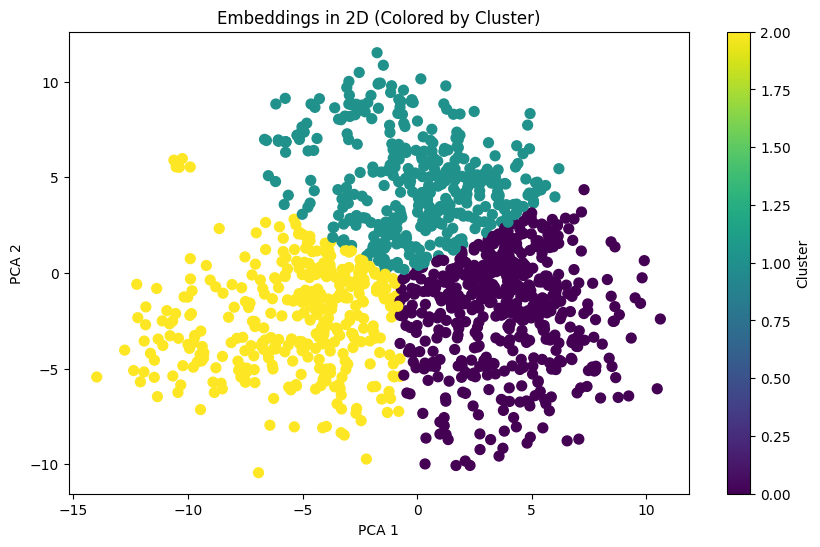

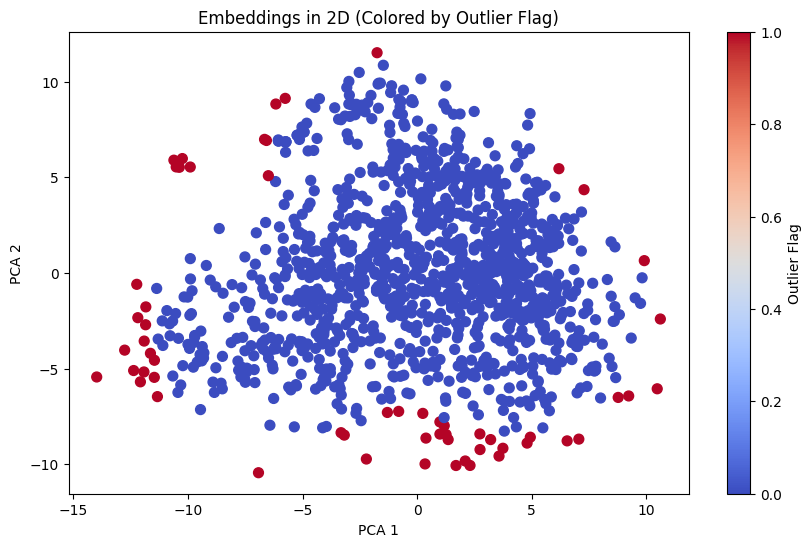

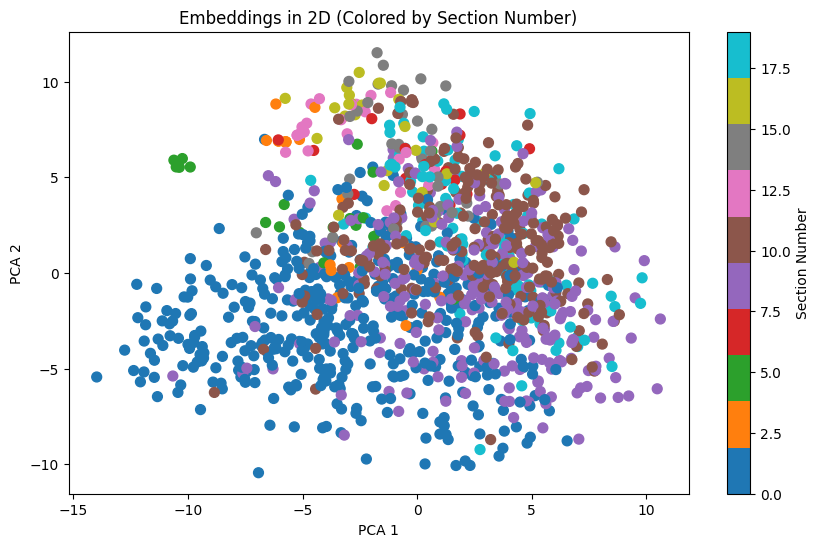

In [63]:
# 5. **Plotting the embeddings**
# a) Plot embeddings colored by cluster
plt.figure(figsize=(10, 6))
plt.scatter(df_reduced["pca_1"], df_reduced["pca_2"], c=df_reduced["cluster"], cmap="viridis", s=50)
plt.title("Embeddings in 2D (Colored by Cluster)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Cluster")
plt.show()

# b) Plot embeddings colored by outlier flag
plt.figure(figsize=(10, 6))
plt.scatter(df_reduced["pca_1"], df_reduced["pca_2"], c=df_reduced["outlier_flag"], cmap="coolwarm", s=50)
plt.title("Embeddings in 2D (Colored by Outlier Flag)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Outlier Flag")
plt.show()

# Convert section_number to categorical numerical values
df_reduced["section_number_numeric"] = pd.factorize(df_reduced["section_number"])[0]

# Plotting the embeddings colored by section number (numeric values)
plt.figure(figsize=(10, 6))
plt.scatter(df_reduced["pca_1"], df_reduced["pca_2"], c=df_reduced["section_number_numeric"], cmap="tab10", s=50)
plt.title("Embeddings in 2D (Colored by Section Number)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar(label="Section Number")
plt.show()
